In [1]:
import numpy as np
import pandas as pd
import os
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras import backend as K
from tqdm import trange
import tensorflow as tf
import gc

from dataloader import get_data, get_weather, get_hod, get_dow, get_train_set_qra, get_test_set_qra

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

Using TensorFlow backend.


In [2]:
def qloss(y_true, y_pred, q):
    tmp1 = (q / 100 - 1) * (y_true - y_pred)
    tmp2 = q / 100 * (y_true - y_pred)
    return K.mean(K.maximum(tmp1, tmp2))

In [3]:
data_set = 'London_2013'
path = os.path.abspath(os.path.join(os.getcwd(), '../..'))

data = get_data(path, data_set)

100%|██████████| 2002/2002 [01:04<00:00, 31.14it/s]


In [4]:
def qloss(y_true, y_pred, q):
    tmp1 = (q / 100 - 1) * (y_true - y_pred)
    tmp2 = q / 100 * (y_true - y_pred)
    return K.mean(K.maximum(tmp1, tmp2))

def train_model_1(train, test, week, day, num_best=8):
    
    # to get the num of samples
    max_lag = 24
    max_d = 2
    trainX, trainTlag, trainTd, trainY = get_train_set_qra(train, week, day, max_lag, max_d)
    n_samples = trainY.shape[0]
    
    error_train_step1 = np.zeros((10, 24, 2))
    error_test_step1 = np.zeros((10, 24, 2))
    pred_train = np.zeros((24, 2, n_samples))
    pred_test = np.zeros((24, 2, 168))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=50)

    for lag in trange(1, 25):
        for d in range(1, 3):
            for _ in range(10):
                trainX, trainTlag, trainTd, trainY = get_train_set_qra(train, week, day, lag, d)
                testX, testTlag, testTd, testY = get_test_set_qra(train, test, week, day, lag, d)

                ## QRA step 1
                # linear model
                inputs = Input((7 + 24 + 3 + lag*3 + d*3,), name='input')
                x = Dense(1, use_bias=True, kernel_initializer='he_normal', bias_initializer='he_normal')(inputs)
                model = Model(inputs=inputs, outputs=x)

                # Train
                model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
                hist1 = model.fit(x=np.hstack((trainX, trainTlag, trainTd)), y=trainY, validation_split=0.2, epochs=1500, verbose=0, callbacks=[early_stopping])

                # Predict (train)
                pred = model.predict(x=np.hstack((trainX, trainTlag, trainTd)))
                error_train_step1[_, lag-1, d-1] = np.sum(np.abs(pred[-n_samples:, :] - trainY[-n_samples:, :]))
                pred_train[lag-1, d-1] = np.squeeze(pred[-n_samples:, :])

                # Predict (test)
                pred = model.predict(x=np.hstack((testX, testTlag, testTd)))
                error_test_step1[_, lag-1, d-1] = np.sum(np.abs(pred - testY))
                pred_test[lag-1, d-1] = np.squeeze(pred)

    # prepare for step 2
#     series_train_1 = pred_train[np.argsort(error_train_step1[:,0])[:num_best//2], 0]
#     series_train_2 = pred_train[np.argsort(error_train_step1[:,1])[:num_best//2], 1]

#     trainX_ = np.vstack((series_train_1, series_train_2)).T
#     trainY_ = trainY[-n_samples:, :].copy()
    
#     series_test_1 = pred_test[np.argsort(error_train_step1[:,0])[:num_best//2], 0]
#     series_test_2 = pred_test[np.argsort(error_train_step1[:,1])[:num_best//2], 1]
    
#     testX_ = np.vstack((series_test_1, series_test_2)).T
#     testY_ = testY
    
    # clear
    del model, pred, hist1
    tf.keras.backend.clear_session()
    gc.collect()
#     return trainX_, trainY_, testX_, testY_
    return error_train_step1, error_test_step1

def train_model_2(trainX_, trainY_, testX_, num_best):
    
    total_pred = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    for q in trange(1, 100):
        
        input_dim = num_best
        model = Sequential([Dense(1, use_bias=True, kernel_initializer='he_normal', bias_initializer='he_normal', input_shape=(input_dim,))])

        # Train
        model.compile(loss=lambda y_true, y_pred: qloss(y_true, y_pred, q), optimizer='adam')
        hist2 = model.fit(x=trainX_, y=trainY_, validation_split=0.2, epochs=1000, verbose=0, callbacks=[early_stopping])

        # Predict (test)
        pred = model.predict(x=testX_)
        total_pred.append(np.squeeze(pred))
    
    total_pred = np.array(total_pred)
    
    del model, pred, hist2
    tf.keras.backend.clear_session()
    gc.collect()
    return total_pred

In [5]:
month = 1
n_clusters = 2
method = 'hierarchical/euclidean'

path_cluster = os.path.join(path, 'result', data_set, 'clustering', 'point', method, f'n_clusters_{n_clusters}.csv')
clusters = pd.read_csv(path_cluster, header=None)

series = data[:, month-1, :months[month-1]*24]
weather = get_weather(path, data_set, month)
week = get_dow(data_set, month)
day = get_hod(month)

In [ ]:
for i in range(n_clusters):

    index = list(clusters[month-1] == i)
    sub_series = series[index]
    sub_series = np.sum(sub_series, axis=0)

    total_series = np.vstack((sub_series, weather))

    test = total_series[:, -168:]
    train = total_series[:, :-168]

    scale = np.zeros(2)
    scale[0] = np.max(train[0])
    scale[1] = np.min(train[0])
    train[0] = (train[0] - scale[1]) / (scale[0] - scale[1])
    test[0] = (test[0] - scale[1]) / (scale[0] - scale[1])

    num_best = 8
    
#     pred_trainX_, pred_trainY_, pred_testX_, pred_testY_ = train_model_1(train, test, week, day, num_best)
    error_train, error_test = train_model_1(train, test, week, day, num_best)
#     pred_series = train_model_2(pred_trainX_, pred_trainY_, pred_testX_, num_best)

    break

 79%|███████▉  | 19/24 [34:57<09:18, 111.73s/it]

In [ ]:
np.save('qra_train.npy', error_train)
np.save('qra_test.npy', error_test)

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

train = np.load('qra_train.npy')
test = np.load('qra_test.npy')

In [39]:
train_sum = np.median(train, axis=0)
test_sum = np.median(test, axis=0)

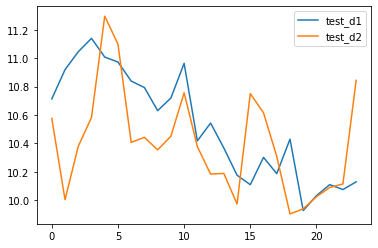

In [40]:
# plt.plot(train_sum[:, 0])
plt.plot(test_sum[:, 0])
# plt.plot(train_sum[:, 1])
plt.plot(test_sum[:, 1])
plt.legend(['test_d1', 'test_d2'], loc='upper right')

In [29]:
np.argsort(train_sum[:, 0])[:10]

array([16, 13, 20, 12, 23, 14, 19, 15, 21, 17])

In [30]:
np.argsort(train_sum[:, 1])[:10]

array([19, 13, 18, 12, 17, 16, 21, 11, 20, 22])

In [31]:
np.argsort(test_sum[:, 0])[:10]

array([19, 20, 22, 15, 21, 23, 14, 17, 16, 13])

In [32]:
np.argsort(test_sum[:, 1])[:10]

array([18, 19, 14,  1, 20, 21, 22, 12, 13, 17])